# <span style="color:blue">Esercitazione 12</span>

### Esercizio 12.1

Si vuole qui costruire e trainare una DNN perché sia poi in grado di riconoscere le $10$ cifre scritte a mano. Sia i dati di training che quelli di test sono presi dal dataset <font face="Courier">MNIST</font>, in cui sono raccolte $7\times10^4$ immagini $28\times28$ pixel in scala di grigi a $256$ gradazioni.

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D

from PIL import Image
import os

seed=0
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
from tensorflow.keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits
# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape); print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples'); print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

60000 train samples
10000 test samples


In [3]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
# cast floats to single precision
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


Le label dei dati sono state convertite in vettori $10$-dimensionali con componenti tutte nulle eccetto quella con l'indice corrispondente alla cifra associata all'immagine. che invece è posta uguale a $1$. In questo modo come funzione costo potrà essere utilizzata in maniera naturale la *categorical crossentropy*. Contemporaneamente sarà monitorata l'*accuracy* dei risultati, ovvero la percentuale di dati labellati correttamente dalla rete.

Volendo in questo contesto usare una DNN, le immagini sono state rese dei vettori monodimensionali.

Come funzione di attivazione ho scelto per ognuno dei layer nascosti la *relu*, mentre per il layer di output è necessario usare una funzione come la *softmax*, in grado di fornire un output finale sotto forma di una serie di $10$ probabilità, una per ognuno dei $10$ neuroni, cioè delle classi finali possibili. L'indice corrispondente alla probabilità più alta corrisponderà così alla cifra associata dalla macchina all'immagine analizzata.

Per l'ottimizzatore ho eseguito tre prove, utilizzando in ordine lo *stochastic gradient descent*, *Adam* e *Adadelta*.

In [4]:
def create_DNN():
    model = Sequential()
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def compile_model(optimizer):
    model=create_DNN()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

def train_model(optimizer):
    model = compile_model(optimizer)
    history = model.fit(X_train, Y_train,
          batch_size=batch_size, epochs=epochs,
          verbose=1, shuffle=True,    # shuffle can improve stability of the model
          validation_data=(X_test, Y_test))
    return model,history

Costruisco per prima la rete con lo SGD.

In [5]:
batch_size = 32; epochs = 10            # training parameters
model_DNN,history = train_model(SGD())  # train DNN and store training info in history

Epoch 1/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.9780 - accuracy: 0.6801 - val_loss: 0.3216 - val_accuracy: 0.9070
Epoch 2/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.4498 - accuracy: 0.8695 - val_loss: 0.2340 - val_accuracy: 0.9306
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3484 - accuracy: 0.9002 - val_loss: 0.1906 - val_accuracy: 0.9444
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2938 - accuracy: 0.9158 - val_loss: 0.1607 - val_accuracy: 0.9516
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2575 - accuracy: 0.9282 - val_loss: 0.1456 - val_accuracy: 0.9547
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2328 - accuracy: 0.9346 - val_loss: 0.1345 - val_accuracy: 0.9583
Epoch 7/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.2099 - accuracy: 0.9404 - val_loss: 0.1225 - val_accur

In [6]:
def evaluate(model):   # evaluate model
    score = model.evaluate(X_test, Y_test, verbose=1)
    # print performance
    print()
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

def plot_hist(history):
    plt.figure(figsize=(15,4)); sub=1
    for fc in ('accuracy','loss'):
        plt.subplot(1,2,sub)
        plt.plot(history.history[fc])
        plt.plot(history.history['val_'+fc])
        plt.ylabel('model '+fc)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='best')
        sub+=1
    plt.show()

313/313 [==============================] - 2s 8ms/step - loss: 0.1040 - accuracy: 0.9674

Test loss: 0.10398013889789581
Test accuracy: 0.9674000144004822


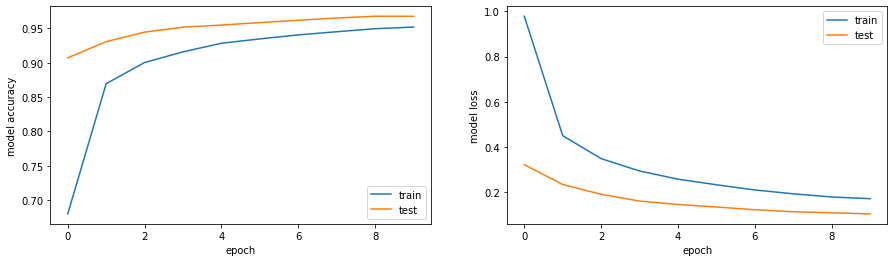

In [7]:
evaluate(model_DNN)
plot_hist(history)

Qui il fatto che le prestazioni siano peggiori in fase di training che in quella di test sono probabilmente dovuti soprattutto all'utilizzo di layer di dropout, che escludono alcuni neuroni dalla rete solo in fase di training. I layer di questo tipo sono presenti per ridurre il pericolo di overfitting. Il fatto che la loss di validazione continua a scendere per tutta la simulazione indica appunto che non si è arrivati a fare overfit dei dati.

In [8]:
def predictions(model):
    pred = model.predict(X_test)

    X_test_ = X_test.reshape(X_test.shape[0], img_rows, img_cols)
    plt.figure(figsize=(15, 15)) 
    for i in range(10):    
        ax = plt.subplot(1, 10, i + 1)    
        plt.imshow(X_test_[i, :, :], cmap='gray')    
        plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(pred[i])))    
        plt.axis('off') 
    plt.show()

La prima delle tre DNN è stata trainata. Qui sotto le predizioni sui dati di test.

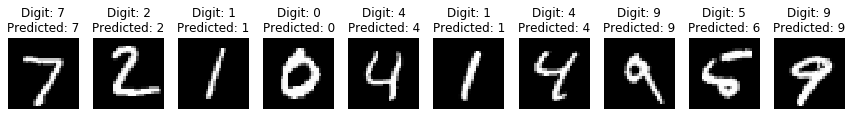

In [9]:
predictions(model_DNN)

Il potere predittivo è piuttosto elevato (l'accuracy di test è sopra il $96\%$). Questo però può essere legato al fatto che le cifre di validazione sono prese dallo stesso dataset di quelle di training. Rimando all'ultimo esercizio per l'utilizzo delle reti per analizzare cifre scritte a mano da me.

Passo all'utilizzo di una rete con struttura identica alla precedente, ma ottimizzata con Adam. Tutte le altre impostazioni e tutti gli altri parametri sono lasciati invariati.

In [10]:
DNN1,histDNN1 = train_model(Adam())

Epoch 1/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3756 - accuracy: 0.8883 - val_loss: 0.1302 - val_accuracy: 0.9608
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1965 - accuracy: 0.9448 - val_loss: 0.1098 - val_accuracy: 0.9658
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1655 - accuracy: 0.9537 - val_loss: 0.1067 - val_accuracy: 0.9668
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1412 - accuracy: 0.9600 - val_loss: 0.0931 - val_accuracy: 0.9733
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1282 - accuracy: 0.9635 - val_loss: 0.0912 - val_accuracy: 0.9758
Epoch 6/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.1206 - accuracy: 0.9664 - val_loss: 0.0819 - val_accuracy: 0.9757
Epoch 7/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.1080 - accuracy: 0.9698 - val_loss: 0.0750 - val_

313/313 [==============================] - 1s 2ms/step - loss: 0.0753 - accuracy: 0.9796

Test loss: 0.0752505213022232
Test accuracy: 0.9796000123023987


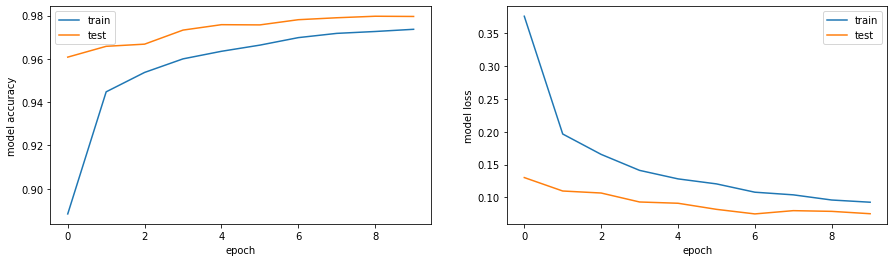

In [11]:
evaluate(DNN1)
plot_hist(histDNN1)

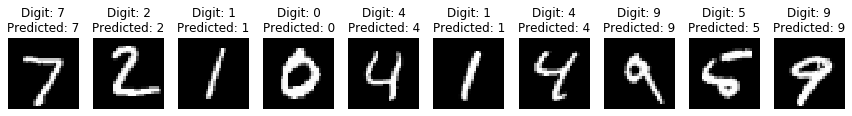

In [12]:
predictions(DNN1)

I risultati ottenuti sono ancora migliori e la accuracy raggiunge quasi il $98\%$. Tra le DNN sarà questa quella usata nell'ultimo esercizio.

Ho provato infine ad usare Adamax. Questo ottimizzatore è risultato molto meno efficiente dei precedenti, e sono quindi stato costretto a raddoppiare il numero di epoche.

In [13]:
epochs=20    # double the epochs
DNN2,histDNN2 = train_model(Adadelta())

Epoch 1/20
1875/1875 [==============================] - 27s 15ms/step - loss: 2.3427 - accuracy: 0.1191 - val_loss: 2.2306 - val_accuracy: 0.2429
Epoch 2/20
1875/1875 [==============================] - 25s 14ms/step - loss: 2.2666 - accuracy: 0.1525 - val_loss: 2.1533 - val_accuracy: 0.3721
Epoch 3/20
1875/1875 [==============================] - 14s 8ms/step - loss: 2.2023 - accuracy: 0.1949 - val_loss: 2.0765 - val_accuracy: 0.4504
Epoch 4/20
1875/1875 [==============================] - 13s 7ms/step - loss: 2.1377 - accuracy: 0.2387 - val_loss: 1.9945 - val_accuracy: 0.5135
Epoch 5/20
1875/1875 [==============================] - 10s 6ms/step - loss: 2.0704 - accuracy: 0.2851 - val_loss: 1.9054 - val_accuracy: 0.5659
Epoch 6/20
1875/1875 [==============================] - 12s 6ms/step - loss: 1.9950 - accuracy: 0.3279 - val_loss: 1.8088 - val_accuracy: 0.6150
Epoch 7/20
1875/1875 [==============================] - 12s 6ms/step - loss: 1.9211 - accuracy: 0.3659 - val_loss: 1.7081 - val_

313/313 [==============================] - 3s 9ms/step - loss: 0.7942 - accuracy: 0.8192

Test loss: 0.7941563725471497
Test accuracy: 0.8191999793052673


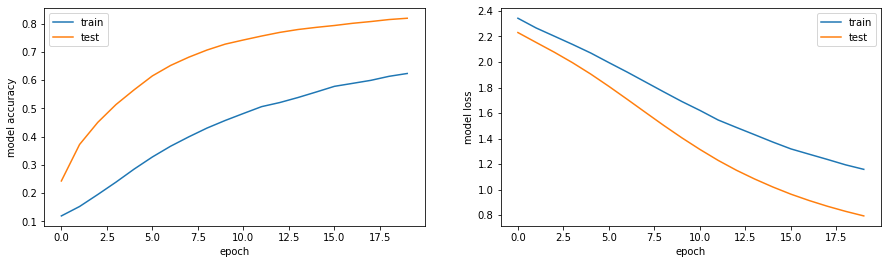

In [14]:
evaluate(DNN2)
plot_hist(histDNN2)

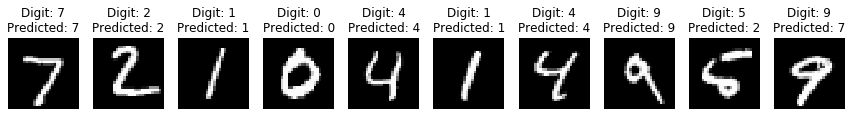

In [15]:
predictions(DNN2)

Le prestazioni in questo caso sono decisamente peggiori (l'accuracy supera appena l'$80\%$). Probabilmente aumentando ancora il numero di generazioni nella fase di training i risultati potrebbero migliorare, ma a questo punto è meglio concentrare gli sforzi sulla rete precedente.

### Esercizio 12.2

Provo ora a risolvere lo stesso problema di classificazione con una CNN, che dovrebbe essere maggiormente in grado di cogliere correlazioni spaziali locali tra i vari pixel. In questo contesto i dati devono essere riconvertiti in formato $28\times28\times1$, dove l'ultimo valore si riferisce al numero di canali (qui $1$ perché le immagini sono in scala di grigio). La struttura del layer di output non può che essere lasciata invariata.

In [16]:
# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)


In [17]:
def create_CNN():
    # Conv2D(#filters, submatrix of previous layer size, activation, ...)
    model = Sequential()
    model.add(Conv2D(10, kernel_size=(5,5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
    model.add(Conv2D(16, kernel_size=(5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
    model.add(Flatten())    # from now on 1D layers
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer='Adam', metrics=['accuracy'])
    return model

In [18]:
batch_size = 32; epochs = 10
CNN=create_CNN()
histCNN = CNN.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(X_test, Y_test))

Epoch 1/10
1875/1875 [==============================] - 34s 18ms/step - loss: 0.2663 - accuracy: 0.9168 - val_loss: 0.0625 - val_accuracy: 0.9812
Epoch 2/10
1875/1875 [==============================] - 31s 16ms/step - loss: 0.1131 - accuracy: 0.9653 - val_loss: 0.0451 - val_accuracy: 0.9857
Epoch 3/10
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0882 - accuracy: 0.9725 - val_loss: 0.0336 - val_accuracy: 0.9893
Epoch 4/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0767 - accuracy: 0.9762 - val_loss: 0.0357 - val_accuracy: 0.9891
Epoch 5/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0685 - accuracy: 0.9786 - val_loss: 0.0340 - val_accuracy: 0.9881
Epoch 6/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0615 - accuracy: 0.9809 - val_loss: 0.0293 - val_accuracy: 0.9903
Epoch 7/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0592 - accuracy: 0.9817 - val_loss: 0.0298 -

313/313 [==============================] - 2s 6ms/step - loss: 0.0266 - accuracy: 0.9915

Test loss: 0.02662784978747368
Test accuracy: 0.9915000200271606


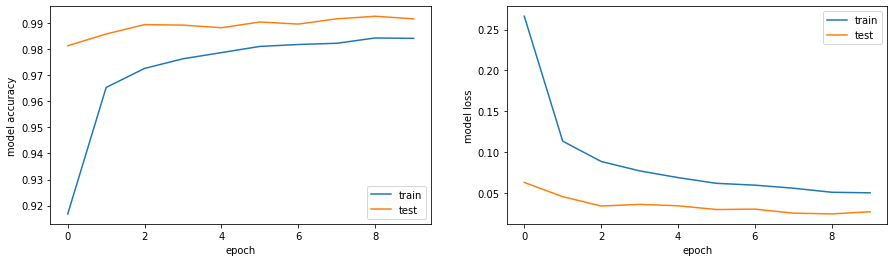

In [19]:
evaluate(CNN)
plot_hist(histCNN)

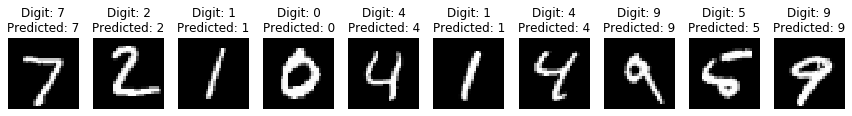

In [20]:
predictions(CNN)

La CNN è, come ci si poteva aspettare, più accurata e molto più efficiente delle DNN. Già da subito infatti l'accuracy è sopra a quelle finali delle reti precedenti, e arriva a superare abbastanza presto il $99\%$.

### Esercizio 12.3

Provo infine a verificare se le reti precedentemente trainate (la CNN e la più efficiente tra le DNN) siano in grado di riconoscere correttamente delle cifre scritte a mano da me tramite l'applicazione <font face="Courier">gimp</font>.

Image size: 28x28


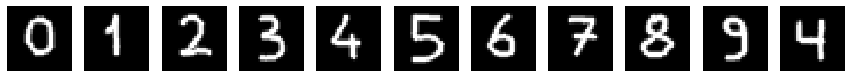

In [21]:
plt.figure(figsize=(15, 15)) 
name_in=list(str(i)+'a' for i in range(10))+['4b']
for i in range(11):
    digit_filename = name_in[i]+".png"
    digit_in = Image.open(digit_filename).convert('L')
    if i==0:
        ydim, xdim = digit_in.size
        data = np.zeros((11,xdim, ydim))
        print("Image size: "+str(xdim)+"x"+str(ydim))
    pix=digit_in.load();
    for j in range(ydim):
        for k in range(xdim):
            data[i,k,j]=pix[j,k]
    ax = plt.subplot(1, 11, i + 1)
    plt.imshow(data[i], cmap='gray')  
    plt.axis('off')

data /= 255
plt.show()

Seguono in ordine le previsioni ottenute con la DNN ottimizzata con Adam e quelle fornite dalla CNN.

In [22]:
def new_pred(model):
    plt.figure(figsize=(15, 15)) 
    for i in range(11):
        ax = plt.subplot(1, 11, i + 1)    
        plt.imshow(data[i], cmap='gray')     
        plt.title("pred:    {}".format(np.argmax(pred[i])))   
        plt.axis('off') 
    plt.show()

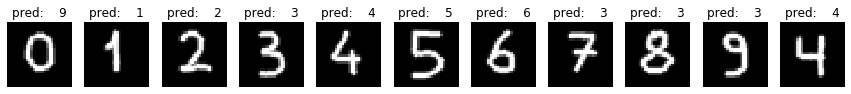

In [23]:
data = data.reshape(11,xdim*ydim)
pred = DNN1.predict(data)
data = data.reshape(11,xdim,ydim)
new_pred(DNN1)

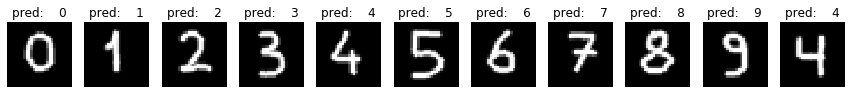

In [24]:
data = data.reshape(11,xdim,ydim,1)
pred = CNN.predict(data)
data = data.reshape(11,xdim,ydim)
new_pred(CNN)

Con le cifre scritte a mano da me risulta evidente la maggior efficacia della CNN rispetto alla DNN in questo problema di image processing.